In [1]:
!pip -q install torchcodec

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 53.2 MB/s eta 0:00:00


In [2]:
import os, time, random, math
from pathlib import Path

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchaudio

from torch.utils.data import Dataset, DataLoader


In [5]:
from google.colab import drive
drive.mount('/content/drive')

SEED = 42
random.seed(SEED); np.random.seed(SEED)
torch.manual_seed(SEED); torch.cuda.manual_seed_all(SEED)

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("DEVICE:", DEVICE)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
DEVICE: cuda


In [6]:
!mkdir -p /content/openmic-2018-2
!mkdir -p /content/sentetik-dataset

# Copy OpenMIC audio folder + metadata files
!cp -r "/content/drive/MyDrive/openmic-2018-2/audio" "/content/openmic-2018-2/"
!cp "/content/drive/MyDrive/openmic-2018-2/openmic-2018-aggregated-labels.csv" "/content/openmic-2018-2/" || true
!cp "/content/drive/MyDrive/openmic-2018-2/openmic-2018-metadata.csv" "/content/openmic-2018-2/" || true

# Copy Synthetic audio + labels
!cp -r "/content/drive/MyDrive/deep_learning/sentetik-dataset/audio" "/content/sentetik-dataset/"
!cp "/content/drive/MyDrive/deep_learning/sentetik-dataset/labels.csv" "/content/sentetik-dataset/"

!du -sh /content/openmic-2018-2 || true
!du -sh /content/sentetik-dataset || true


2.5G	/content/openmic-2018-2
680M	/content/sentetik-dataset


#  4 — Patch combined CSV paths to local and validate

In [7]:
CSV_PATH = Path("/content/drive/MyDrive/deep_learning/combined_openmic_and_synth.csv")
df = pd.read_csv(CSV_PATH, low_memory=False)

# Patch to local /content paths
df["path"] = df["path"].astype(str).str.replace(
    "/content/drive/MyDrive/openmic-2018-2",
    "/content/openmic-2018-2",
    regex=False
).str.replace(
    "/content/drive/MyDrive/deep_learning/sentetik-dataset",
    "/content/sentetik-dataset",
    regex=False
)

# Save local version (so the rest of the notebook uses a local CSV)
LOCAL_CSV = Path("/content/combined_openmic_and_synth_LOCAL.csv")
df.to_csv(LOCAL_CSV, index=False)
print("Saved:", LOCAL_CSV)

# Sanity check
missing = sum(not Path(p).exists() for p in df["path"].sample(500, random_state=0))
print("Missing paths in sample(500):", missing)
print(df["source"].value_counts())


Saved: /content/combined_openmic_and_synth_LOCAL.csv
Missing paths in sample(500): 0
source
openmic      20000
synthetic     2200
Name: count, dtype: int64


# 5 — Tags, y/m columns, numeric cleanup

In [8]:
COMBINED_CSV = "/content/combined_openmic_and_synth_LOCAL.csv"
df = pd.read_csv(COMBINED_CSV, low_memory=False)

TAGS = [
    "accordion","banjo","bass","cello","clarinet","cymbals","drums","flute","guitar","mallet_percussion",
    "mandolin","organ","piano","saxophone","synthesizer","trombone","trumpet","ukulele","violin","voice"
]
Y_COLS = [f"y_{t}" for t in TAGS]
M_COLS = [f"m_{t}" for t in TAGS]

assert "path" in df.columns and "source" in df.columns, "CSV must include 'path' and 'source'."
assert all(c in df.columns for c in Y_COLS), "Missing y_* columns"
assert all(c in df.columns for c in M_COLS), "Missing m_* columns"

df[Y_COLS] = df[Y_COLS].apply(pd.to_numeric, errors="coerce").fillna(0).astype(np.int64)
df[M_COLS] = df[M_COLS].apply(pd.to_numeric, errors="coerce").fillna(0).astype(np.int64)

print("Rows:", len(df))
print("Sources:", df["source"].value_counts().to_dict())
print("Has split?", "split" in df.columns)


Rows: 22200
Sources: {'openmic': 20000, 'synthetic': 2200}
Has split? False


# 6 — Train/Val/Test split

In [9]:
if "split" not in df.columns:
    rng = np.random.default_rng(SEED)
    idx = np.arange(len(df))
    rng.shuffle(idx)
    n = len(df)

    n_train = int(0.80*n)
    n_val   = int(0.10*n)

    split = np.empty(n, dtype=object)
    split[idx[:n_train]] = "train"
    split[idx[n_train:n_train+n_val]] = "val"
    split[idx[n_train+n_val:]] = "test"
    df["split"] = split

    df.to_csv(COMBINED_CSV, index=False)
    print("Saved split into:", COMBINED_CSV)
else:
    print("Using existing split.")

train_df = df[df["split"]=="train"].reset_index(drop=True)
val_df   = df[df["split"]=="val"].reset_index(drop=True)
test_df  = df[df["split"]=="test"].reset_index(drop=True)

print("Split sizes:", {k: int((df["split"]==k).sum()) for k in ["train","val","test"]})


Saved split into: /content/combined_openmic_and_synth_LOCAL.csv
Split sizes: {'train': 17760, 'val': 2220, 'test': 2220}


# 7 — Audio loading + log-mel (NaN-safe)

In [10]:
TARGET_SR = 16000
DUR_SEC = 10
TARGET_LEN = TARGET_SR * DUR_SEC

N_FFT = 1024
HOP = 320
WIN = 1024
N_MELS = 128

mel = torchaudio.transforms.MelSpectrogram(
    sample_rate=TARGET_SR,
    n_fft=N_FFT,
    hop_length=HOP,
    win_length=WIN,
    n_mels=N_MELS,
    power=2.0,
).to(DEVICE)

def load_audio(path: str):
    wav, sr = torchaudio.load(path)  # [C,T]
    if wav.size(0) > 1:
        wav = wav.mean(dim=0, keepdim=True)
    if sr != TARGET_SR:
        wav = torchaudio.functional.resample(wav, sr, TARGET_SR)
    T = wav.size(1)
    if T < TARGET_LEN:
        wav = F.pad(wav, (0, TARGET_LEN - T))
    else:
        wav = wav[:, :TARGET_LEN]
    return wav  # [1,T]

def wav_to_logmel(wav_batch: torch.Tensor):
    # [B,1,T] -> [B,128,TT]
    x = wav_batch.squeeze(1)         # [B,T]
    M = mel(x)                       # [B,128,TT]
    M = torch.log(M + 1e-6)
    M = torch.nan_to_num(M, nan=0.0, posinf=0.0, neginf=0.0)

    mean = M.mean(dim=(1,2), keepdim=True)
    std  = M.std(dim=(1,2), keepdim=True).clamp_min(1e-6)
    return (M - mean) / std


# 8 — Dataset + DataLoaders

In [11]:
class AudioTagDataset(Dataset):
    def __init__(self, df):
        self.paths = df["path"].astype(str).tolist()
        self.y = df[Y_COLS].values.astype(np.float32)
        self.m = df[M_COLS].values.astype(np.float32)
        self.src = df["source"].astype(str).tolist()

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        wav = load_audio(self.paths[idx])  # [1,T]
        y = torch.from_numpy(self.y[idx])  # [20]
        m = torch.from_numpy(self.m[idx])  # [20]
        return wav, y, m, self.src[idx]

def collate_fn(batch):
    wavs, ys, ms, srcs = zip(*batch)
    wavs = torch.stack(wavs).float()
    ys   = torch.stack(ys).float()
    ms   = torch.stack(ms).float()
    return wavs, ys, ms, srcs

BATCH_SIZE = 128    # A100 target; if OOM -> 64
NUM_WORKERS = 4

train_loader = DataLoader(AudioTagDataset(train_df), batch_size=BATCH_SIZE, shuffle=True,
                          num_workers=NUM_WORKERS, pin_memory=True, collate_fn=collate_fn, drop_last=True)
val_loader   = DataLoader(AudioTagDataset(val_df), batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=NUM_WORKERS, pin_memory=True, collate_fn=collate_fn)
test_loader  = DataLoader(AudioTagDataset(test_df), batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=NUM_WORKERS, pin_memory=True, collate_fn=collate_fn)

print("Loaders ready.")


Loaders ready.


# 9 — Quick smoke test

In [12]:
model_wav, model_y, model_m, _ = next(iter(train_loader))
model_wav = model_wav.to(DEVICE)
logmel_test = wav_to_logmel(model_wav)
print("wav:", tuple(model_wav.shape), "logmel:", tuple(logmel_test.shape),
      "finite:", torch.isfinite(logmel_test).all().item(),
      "min/max:", float(logmel_test.min()), float(logmel_test.max()))


wav: (128, 1, 160000) logmel: (128, 128, 501) finite: True min/max: -10.768610954284668 6.0221428871154785


# 10 — pos_weight from TRAIN (masked)

In [13]:
Y = train_df[Y_COLS].values.astype(np.float64)
M = train_df[M_COLS].values.astype(np.float64)

pos = (Y * M).sum(axis=0)
tot = M.sum(axis=0)
neg = (tot - pos).clip(min=1.0)

pos_weight = torch.tensor((neg / np.clip(pos, 1.0, None)), dtype=torch.float32, device=DEVICE)
pos_weight = torch.clamp(pos_weight, 1.0, 50.0)
print("pos_weight min/median/max:", float(pos_weight.min()), float(pos_weight.median()), float(pos_weight.max()))


pos_weight min/median/max: 8.202072143554688 16.349620819091797 40.3963737487793


# 11 — Multi-Scale CRNN model

In [14]:
class MultiScaleConvBlock(nn.Module):
    def __init__(self, in_ch=1, out_ch=32):
        super().__init__()
        self.b1 = nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1)
        self.b2 = nn.Conv2d(in_ch, out_ch, kernel_size=5, padding=2)
        self.b3 = nn.Conv2d(in_ch, out_ch, kernel_size=7, padding=3)
        self.bn = nn.BatchNorm2d(out_ch*3)
        self.act = nn.ReLU(inplace=True)
        self.pool = nn.MaxPool2d(kernel_size=(2,2))

    def forward(self, x):
        y = torch.cat([self.b1(x), self.b2(x), self.b3(x)], dim=1)
        y = self.act(self.bn(y))
        return self.pool(y)

class MSCRNN(nn.Module):
    def __init__(self, n_tags=20, base=32, rnn_hidden=256, rnn_layers=2, dropout=0.3):
        super().__init__()
        self.ms1 = MultiScaleConvBlock(1, base)
        self.ms2 = MultiScaleConvBlock(base*3, base)
        self.ms3 = MultiScaleConvBlock(base*3, base)
        self.drop2d = nn.Dropout2d(dropout)

        self.rnn = nn.GRU(
            input_size=base*3,
            hidden_size=rnn_hidden,
            num_layers=rnn_layers,
            batch_first=True,
            bidirectional=True,
            dropout=dropout if rnn_layers > 1 else 0.0,
        )

        self.attn = nn.Linear(rnn_hidden*2, 1)
        self.fc = nn.Linear(rnn_hidden*2, n_tags)

    def forward(self, logmel):
        x = logmel.unsqueeze(1)  # [B,1,F,T]
        x = self.drop2d(self.ms1(x))
        x = self.drop2d(self.ms2(x))
        x = self.drop2d(self.ms3(x))

        x = x.mean(dim=2)        # [B,C,T]
        x = x.transpose(1,2)     # [B,T,C]
        x, _ = self.rnn(x)       # [B,T,2H]

        a = torch.softmax(self.attn(x), dim=1)  # [B,T,1]
        z = (a * x).sum(dim=1)                  # [B,2H]
        return self.fc(z)                       # [B,20]

model = MSCRNN(n_tags=len(TAGS)).to(DEVICE)
print("Model ready on", DEVICE)


Model ready on cuda


#  12 — Loss, metrics, optimizer

In [15]:
def masked_bce_with_logits(logits, y, m, pos_weight):
    loss_raw = F.binary_cross_entropy_with_logits(
        logits, y, reduction="none", pos_weight=pos_weight
    )
    return (loss_raw * m).sum() / (m.sum() + 1e-8)

@torch.no_grad()
def macro_f1(probs, y_true, mask, thr=0.2):
    y_pred = (probs >= thr).astype(np.int32)
    f1s = []
    for c in range(y_true.shape[1]):
        valid = mask[:, c] > 0.5
        if valid.sum() == 0:
            continue
        yt = y_true[valid, c]
        yp = y_pred[valid, c]
        tp = np.sum((yt==1) & (yp==1))
        fp = np.sum((yt==0) & (yp==1))
        fn = np.sum((yt==1) & (yp==0))
        denom = (2*tp + fp + fn)
        f1s.append(0.0 if denom == 0 else (2*tp/denom))
    return float(np.mean(f1s)) if f1s else 0.0

LR = 2e-4
WD = 1e-4

optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WD)
scaler = torch.amp.GradScaler("cuda")

print("Optimizer ready.")


Optimizer ready.


# 13 — Train/Eval loops + early stopping + checkpoint

In [16]:
SAVE_DIR = "/content/drive/MyDrive/model_weights/finetuning"
os.makedirs(SAVE_DIR, exist_ok=True)
CKPT_PATH = f"{SAVE_DIR}/mscrnn_openmic_plus_synth_best.pth"

@torch.no_grad()
def eval_loop(loader):
    model.eval()
    losses = []
    probs_all, y_all, m_all = [], [], []

    for wav, y, m, _ in loader:
        wav = wav.to(DEVICE, non_blocking=True)
        y   = y.to(DEVICE, non_blocking=True)
        m   = m.to(DEVICE, non_blocking=True)

        logmel = wav_to_logmel(wav)
        logits = model(logmel)

        loss = masked_bce_with_logits(logits, y, m, pos_weight)
        losses.append(loss.item())

        probs_all.append(torch.sigmoid(logits).cpu().numpy())
        y_all.append(y.cpu().numpy())
        m_all.append(m.cpu().numpy())

    probs = np.concatenate(probs_all, axis=0)
    y_np  = np.concatenate(y_all, axis=0)
    m_np  = np.concatenate(m_all, axis=0)

    f1_02 = macro_f1(probs, y_np, m_np, thr=0.2)
    f1_05 = macro_f1(probs, y_np, m_np, thr=0.5)
    return float(np.mean(losses)), f1_02, f1_05

def train_epoch(epoch, log_every=50, grad_clip=1.0):
    model.train()
    t0 = time.time()
    step_times = []
    losses = []
    total_steps = len(train_loader)

    for step, (wav, y, m, _) in enumerate(train_loader, start=1):
        s0 = time.time()
        wav = wav.to(DEVICE, non_blocking=True)
        y   = y.to(DEVICE, non_blocking=True)
        m   = m.to(DEVICE, non_blocking=True)

        optimizer.zero_grad(set_to_none=True)

        with torch.amp.autocast("cuda"):
            logmel = wav_to_logmel(wav)
            logits = model(logmel)
            loss = masked_bce_with_logits(logits, y, m, pos_weight)

        if not torch.isfinite(loss):
            raise RuntimeError(f"Non-finite loss at epoch {epoch} step {step}: {loss.item()}")

        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
        scaler.step(optimizer)
        scaler.update()

        losses.append(loss.item())
        step_times.append(time.time() - s0)

        if step % log_every == 0:
            sec_step = float(np.mean(step_times[-log_every:]))
            eta_min = (total_steps - step) * sec_step / 60.0
            print(f"epoch {epoch} step {step}/{total_steps} loss {np.mean(losses[-log_every:]):.4f} sec/step {sec_step:.3f} ETA {eta_min:.1f}m")

    return float(np.mean(losses)), time.time() - t0

EPOCHS = 30
PATIENCE = 5
best_val_loss = 1e9
bad = 0

for epoch in range(1, EPOCHS+1):
    tr_loss, tr_time = train_epoch(epoch, log_every=50)
    val_loss, val_f1_02, val_f1_05 = eval_loop(val_loader)

    print(f"epoch {epoch} DONE | {tr_time/60:.1f}m | VAL loss {val_loss:.4f} | VAL macro-F1@0.2 {val_f1_02:.4f} | @0.5 {val_f1_05:.4f}")

    if val_loss < best_val_loss - 1e-4:
        best_val_loss = val_loss
        bad = 0
        torch.save({"model": model.state_dict(), "epoch": epoch, "val_loss": val_loss}, CKPT_PATH)
        print("Saved best:", CKPT_PATH, "val_loss:", best_val_loss)
    else:
        bad += 1
        if bad >= PATIENCE:
            print("Early stopping. Best val_loss:", best_val_loss)
            break


epoch 1 step 50/138 loss 1.2046 sec/step 0.293 ETA 0.4m
epoch 1 step 100/138 loss 1.1136 sec/step 0.206 ETA 0.1m
epoch 1 DONE | 1.6m | VAL loss 1.0347 | VAL macro-F1@0.2 0.1513 | @0.5 0.2800
Saved best: /content/drive/MyDrive/model_weights/finetuning/mscrnn_openmic_plus_synth_best.pth val_loss: 1.0346741676330566
epoch 2 step 50/138 loss 1.0106 sec/step 0.207 ETA 0.3m
epoch 2 step 100/138 loss 0.9971 sec/step 0.205 ETA 0.1m
epoch 2 DONE | 1.6m | VAL loss 0.9745 | VAL macro-F1@0.2 0.1682 | @0.5 0.3071
Saved best: /content/drive/MyDrive/model_weights/finetuning/mscrnn_openmic_plus_synth_best.pth val_loss: 0.9744594858752357
epoch 3 step 50/138 loss 0.9693 sec/step 0.205 ETA 0.3m
epoch 3 step 100/138 loss 0.9582 sec/step 0.206 ETA 0.1m
epoch 3 DONE | 1.6m | VAL loss 0.9353 | VAL macro-F1@0.2 0.1809 | @0.5 0.3252
Saved best: /content/drive/MyDrive/model_weights/finetuning/mscrnn_openmic_plus_synth_best.pth val_loss: 0.9352698889043596
epoch 4 step 50/138 loss 0.9410 sec/step 0.209 ETA 0.3m

In [17]:
ckpt = torch.load(CKPT_PATH, map_location=DEVICE)
model.load_state_dict(ckpt["model"])

test_loss, test_f1_02, test_f1_05 = eval_loop(test_loader)
print("TEST loss:", test_loss)
print("TEST macro-F1@0.2:", test_f1_02)
print("TEST macro-F1@0.5:", test_f1_05)


TEST loss: 0.6561257657077577
TEST macro-F1@0.2: 0.29343376975449853
TEST macro-F1@0.5: 0.40618567419308843


In [18]:
import numpy as np
import pandas as pd
import torch

# --- Ensure these exist from your notebook ---
# TAGS, Y_COLS, M_COLS, DEVICE, model, test_loader, CKPT_PATH
# If model isn't loaded yet, load the best checkpoint:
ckpt = torch.load(CKPT_PATH, map_location=DEVICE)
model.load_state_dict(ckpt["model"])
model.eval()

@torch.no_grad()
def collect_test_probs(model, loader):
    probs_all, y_all, m_all = [], [], []
    for wav, y, m, _ in loader:
        wav = wav.to(DEVICE, non_blocking=True)
        y   = y.to(DEVICE, non_blocking=True)
        m   = m.to(DEVICE, non_blocking=True)

        logmel = wav_to_logmel(wav)
        logits = model(logmel)
        probs = torch.sigmoid(logits)

        probs_all.append(probs.cpu().numpy())
        y_all.append(y.cpu().numpy())
        m_all.append(m.cpu().numpy())

    probs = np.concatenate(probs_all, axis=0)  # [N,20]
    y_np  = np.concatenate(y_all, axis=0)      # [N,20]
    m_np  = np.concatenate(m_all, axis=0)      # [N,20]
    return probs, y_np, m_np

def per_class_prf(y_true, probs, mask, thr):
    rows = []
    for i, tag in enumerate(TAGS):
        valid = mask[:, i] > 0.5
        n_valid = int(valid.sum())
        if n_valid == 0:
            rows.append({
                "tag": tag, "thr": thr,
                "valid_n": 0, "pos_n": 0,
                "precision": np.nan, "recall": np.nan, "f1": np.nan,
                "tp": 0, "fp": 0, "fn": 0
            })
            continue

        yt = y_true[valid, i].astype(np.int32)
        yp = (probs[valid, i] >= thr).astype(np.int32)

        tp = int(((yt == 1) & (yp == 1)).sum())
        fp = int(((yt == 0) & (yp == 1)).sum())
        fn = int(((yt == 1) & (yp == 0)).sum())

        precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
        recall    = tp / (tp + fn) if (tp + fn) > 0 else 0.0
        f1        = (2 * precision * recall / (precision + recall)) if (precision + recall) > 0 else 0.0

        rows.append({
            "tag": tag, "thr": thr,
            "valid_n": n_valid, "pos_n": int(yt.sum()),
            "precision": precision, "recall": recall, "f1": f1,
            "tp": tp, "fp": fp, "fn": fn
        })
    return pd.DataFrame(rows)

# --- Run ---
probs, y_np, m_np = collect_test_probs(model, test_loader)

df_02 = per_class_prf(y_np, probs, m_np, thr=0.2)
df_05 = per_class_prf(y_np, probs, m_np, thr=0.5)

out = pd.concat([df_02, df_05], ignore_index=True)

# Summary + display
print("Macro-F1@0.2:", float(df_02["f1"].mean()))
print("Macro-F1@0.5:", float(df_05["f1"].mean()))

print("\nTop-10 classes by F1@0.5:")
display(df_05.sort_values("f1", ascending=False).head(10))

print("\nBottom-10 classes by F1@0.5:")
display(df_05.sort_values("f1", ascending=True).head(10))

# Save to Drive (optional)
OUT_PATH = "/content/drive/MyDrive/deep_learning/mscrnn_test_per_class_f1.csv"
out.to_csv(OUT_PATH, index=False)
print("\nSaved per-class metrics to:", OUT_PATH)


Macro-F1@0.2: 0.29343376975449853
Macro-F1@0.5: 0.40618567419308843

Top-10 classes by F1@0.5:


,tag,thr,valid_n,pos_n,precision,recall,f1,tp,fp,fn
12,piano,0.5,2220,241,0.494118,0.871369,0.630631,210,215,31
9,mallet_percussion,0.5,2220,191,0.483384,0.837696,0.613027,160,171,31
11,organ,0.5,2220,189,0.428218,0.915344,0.583474,173,231,16
7,flute,0.5,2220,201,0.453039,0.815920,0.582593,164,198,37
19,voice,0.5,2220,215,0.445844,0.823256,0.578431,177,220,38
2,bass,0.5,2220,182,0.416021,0.884615,0.565905,161,226,21
14,synthesizer,0.5,2220,231,0.419492,0.857143,0.563300,198,274,33
6,drums,0.5,2003,135,0.389058,0.948148,0.551724,128,201,7
8,guitar,0.5,2220,235,0.376623,0.863830,0.524548,203,336,32
5,cymbals,0.5,2003,131,0.340237,0.877863,0.490405,115,223,16



Bottom-10 classes by F1@0.5:


,tag,thr,valid_n,pos_n,precision,recall,f1,tp,fp,fn
4,clarinet,0.5,2003,47,0.075000,0.893617,0.138386,42,518,5
0,accordion,0.5,2003,48,0.084270,0.937500,0.154639,45,489,3
15,trombone,0.5,2003,85,0.101469,0.894118,0.182254,76,673,9
16,trumpet,0.5,2003,96,0.120666,0.906250,0.212974,87,634,9
1,banjo,0.5,2003,70,0.137168,0.885714,0.237548,62,390,8
17,ukulele,0.5,2003,60,0.141791,0.950000,0.246753,57,345,3
3,cello,0.5,2003,85,0.151571,0.964706,0.261981,82,459,3
13,saxophone,0.5,2003,103,0.154093,0.932039,0.264463,96,527,7
10,mandolin,0.5,2003,86,0.203343,0.848837,0.328090,73,286,13
18,violin,0.5,2003,128,0.265766,0.921875,0.412587,118,326,10



Saved per-class metrics to: /content/drive/MyDrive/deep_learning/mscrnn_test_per_class_f1.csv


Parsed epochs: 30


,epoch,val_loss,val_f1_02,val_f1_05
0,1,1.0347,0.1513,0.2800
1,2,0.9745,0.1682,0.3071
2,3,0.9353,0.1809,0.3252
3,4,0.8805,0.1943,0.3301
4,5,0.8565,0.2017,0.3358


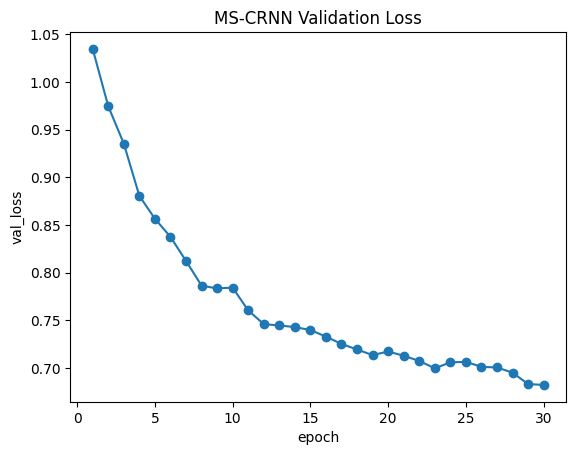

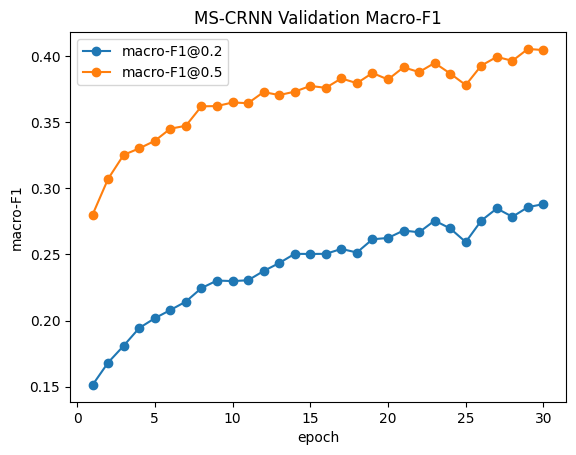

In [19]:
import re
import pandas as pd
import matplotlib.pyplot as plt

LOG_TEXT = r"""
epoch 1 step 50/138 loss 1.2046 sec/step 0.293 ETA 0.4m
epoch 1 step 100/138 loss 1.1136 sec/step 0.206 ETA 0.1m
epoch 1 DONE | 1.6m | VAL loss 1.0347 | VAL macro-F1@0.2 0.1513 | @0.5 0.2800
Saved best: /content/drive/MyDrive/model_weights/finetuning/mscrnn_openmic_plus_synth_best.pth val_loss: 1.0346741676330566
epoch 2 step 50/138 loss 1.0106 sec/step 0.207 ETA 0.3m
epoch 2 step 100/138 loss 0.9971 sec/step 0.205 ETA 0.1m
epoch 2 DONE | 1.6m | VAL loss 0.9745 | VAL macro-F1@0.2 0.1682 | @0.5 0.3071
Saved best: /content/drive/MyDrive/model_weights/finetuning/mscrnn_openmic_plus_synth_best.pth val_loss: 0.9744594858752357
epoch 3 step 50/138 loss 0.9693 sec/step 0.205 ETA 0.3m
epoch 3 step 100/138 loss 0.9582 sec/step 0.206 ETA 0.1m
epoch 3 DONE | 1.6m | VAL loss 0.9353 | VAL macro-F1@0.2 0.1809 | @0.5 0.3252
Saved best: /content/drive/MyDrive/model_weights/finetuning/mscrnn_openmic_plus_synth_best.pth val_loss: 0.9352698889043596
epoch 4 step 50/138 loss 0.9410 sec/step 0.209 ETA 0.3m
epoch 4 step 100/138 loss 0.9182 sec/step 0.205 ETA 0.1m
epoch 4 DONE | 1.6m | VAL loss 0.8805 | VAL macro-F1@0.2 0.1943 | @0.5 0.3301
Saved best: /content/drive/MyDrive/model_weights/finetuning/mscrnn_openmic_plus_synth_best.pth val_loss: 0.8805005053679148
epoch 5 step 50/138 loss 0.9163 sec/step 0.204 ETA 0.3m
epoch 5 step 100/138 loss 0.8806 sec/step 0.199 ETA 0.1m
epoch 5 DONE | 1.6m | VAL loss 0.8565 | VAL macro-F1@0.2 0.2017 | @0.5 0.3358
Saved best: /content/drive/MyDrive/model_weights/finetuning/mscrnn_openmic_plus_synth_best.pth val_loss: 0.8564969599246979
epoch 6 step 50/138 loss 0.8674 sec/step 0.208 ETA 0.3m
epoch 6 step 100/138 loss 0.8721 sec/step 0.207 ETA 0.1m
epoch 6 DONE | 1.6m | VAL loss 0.8375 | VAL macro-F1@0.2 0.2079 | @0.5 0.3450
Saved best: /content/drive/MyDrive/model_weights/finetuning/mscrnn_openmic_plus_synth_best.pth val_loss: 0.8374910851319631
epoch 7 step 50/138 loss 0.8538 sec/step 0.206 ETA 0.3m
epoch 7 step 100/138 loss 0.8347 sec/step 0.206 ETA 0.1m
epoch 7 DONE | 1.6m | VAL loss 0.8122 | VAL macro-F1@0.2 0.2143 | @0.5 0.3472
Saved best: /content/drive/MyDrive/model_weights/finetuning/mscrnn_openmic_plus_synth_best.pth val_loss: 0.8121781051158905
epoch 8 step 50/138 loss 0.8469 sec/step 0.207 ETA 0.3m
epoch 8 step 100/138 loss 0.8194 sec/step 0.204 ETA 0.1m
epoch 8 DONE | 1.6m | VAL loss 0.7863 | VAL macro-F1@0.2 0.2245 | @0.5 0.3619
Saved best: /content/drive/MyDrive/model_weights/finetuning/mscrnn_openmic_plus_synth_best.pth val_loss: 0.7862678898705376
epoch 9 step 50/138 loss 0.8139 sec/step 0.207 ETA 0.3m
epoch 9 step 100/138 loss 0.8155 sec/step 0.209 ETA 0.1m
epoch 9 DONE | 1.6m | VAL loss 0.7834 | VAL macro-F1@0.2 0.2302 | @0.5 0.3621
Saved best: /content/drive/MyDrive/model_weights/finetuning/mscrnn_openmic_plus_synth_best.pth val_loss: 0.7834439443217384
epoch 10 step 50/138 loss 0.8015 sec/step 0.206 ETA 0.3m
epoch 10 step 100/138 loss 0.7948 sec/step 0.203 ETA 0.1m
epoch 10 DONE | 1.6m | VAL loss 0.7842 | VAL macro-F1@0.2 0.2298 | @0.5 0.3648
epoch 11 step 50/138 loss 0.7683 sec/step 0.204 ETA 0.3m
epoch 11 step 100/138 loss 0.7941 sec/step 0.202 ETA 0.1m
epoch 11 DONE | 1.6m | VAL loss 0.7603 | VAL macro-F1@0.2 0.2304 | @0.5 0.3643
Saved best: /content/drive/MyDrive/model_weights/finetuning/mscrnn_openmic_plus_synth_best.pth val_loss: 0.7602974341975318
epoch 12 step 50/138 loss 0.7727 sec/step 0.207 ETA 0.3m
epoch 12 step 100/138 loss 0.7590 sec/step 0.204 ETA 0.1m
epoch 12 DONE | 1.6m | VAL loss 0.7459 | VAL macro-F1@0.2 0.2374 | @0.5 0.3727
Saved best: /content/drive/MyDrive/model_weights/finetuning/mscrnn_openmic_plus_synth_best.pth val_loss: 0.7459125485685136
epoch 13 step 50/138 loss 0.7677 sec/step 0.206 ETA 0.3m
epoch 13 step 100/138 loss 0.7649 sec/step 0.202 ETA 0.1m
epoch 13 DONE | 1.6m | VAL loss 0.7445 | VAL macro-F1@0.2 0.2434 | @0.5 0.3704
Saved best: /content/drive/MyDrive/model_weights/finetuning/mscrnn_openmic_plus_synth_best.pth val_loss: 0.7444952130317688
epoch 14 step 50/138 loss 0.7620 sec/step 0.206 ETA 0.3m
epoch 14 step 100/138 loss 0.7569 sec/step 0.204 ETA 0.1m
epoch 14 DONE | 1.6m | VAL loss 0.7428 | VAL macro-F1@0.2 0.2504 | @0.5 0.3730
Saved best: /content/drive/MyDrive/model_weights/finetuning/mscrnn_openmic_plus_synth_best.pth val_loss: 0.7427793542544047
epoch 15 step 50/138 loss 0.7414 sec/step 0.206 ETA 0.3m
epoch 15 step 100/138 loss 0.7506 sec/step 0.207 ETA 0.1m
epoch 15 DONE | 1.6m | VAL loss 0.7397 | VAL macro-F1@0.2 0.2503 | @0.5 0.3773
Saved best: /content/drive/MyDrive/model_weights/finetuning/mscrnn_openmic_plus_synth_best.pth val_loss: 0.7396856579515669
epoch 16 step 50/138 loss 0.7350 sec/step 0.207 ETA 0.3m
epoch 16 step 100/138 loss 0.7490 sec/step 0.203 ETA 0.1m
epoch 16 DONE | 1.6m | VAL loss 0.7328 | VAL macro-F1@0.2 0.2504 | @0.5 0.3759
Saved best: /content/drive/MyDrive/model_weights/finetuning/mscrnn_openmic_plus_synth_best.pth val_loss: 0.7327800591786703
epoch 17 step 50/138 loss 0.7388 sec/step 0.207 ETA 0.3m
epoch 17 step 100/138 loss 0.7199 sec/step 0.204 ETA 0.1m
epoch 17 DONE | 1.6m | VAL loss 0.7251 | VAL macro-F1@0.2 0.2541 | @0.5 0.3830
Saved best: /content/drive/MyDrive/model_weights/finetuning/mscrnn_openmic_plus_synth_best.pth val_loss: 0.7251167429818047
epoch 18 step 50/138 loss 0.7240 sec/step 0.208 ETA 0.3m
epoch 18 step 100/138 loss 0.7192 sec/step 0.203 ETA 0.1m
epoch 18 DONE | 1.6m | VAL loss 0.7193 | VAL macro-F1@0.2 0.2514 | @0.5 0.3794
Saved best: /content/drive/MyDrive/model_weights/finetuning/mscrnn_openmic_plus_synth_best.pth val_loss: 0.7193446291817559
epoch 19 step 50/138 loss 0.7190 sec/step 0.204 ETA 0.3m
epoch 19 step 100/138 loss 0.7137 sec/step 0.204 ETA 0.1m
epoch 19 DONE | 1.6m | VAL loss 0.7134 | VAL macro-F1@0.2 0.2614 | @0.5 0.3871
Saved best: /content/drive/MyDrive/model_weights/finetuning/mscrnn_openmic_plus_synth_best.pth val_loss: 0.7134195963541666
epoch 20 step 50/138 loss 0.7088 sec/step 0.206 ETA 0.3m
epoch 20 step 100/138 loss 0.7053 sec/step 0.207 ETA 0.1m
epoch 20 DONE | 1.6m | VAL loss 0.7172 | VAL macro-F1@0.2 0.2624 | @0.5 0.3822
epoch 21 step 50/138 loss 0.7047 sec/step 0.206 ETA 0.3m
epoch 21 step 100/138 loss 0.6916 sec/step 0.206 ETA 0.1m
epoch 21 DONE | 1.6m | VAL loss 0.7127 | VAL macro-F1@0.2 0.2680 | @0.5 0.3914
Saved best: /content/drive/MyDrive/model_weights/finetuning/mscrnn_openmic_plus_synth_best.pth val_loss: 0.7126673658688863
epoch 22 step 50/138 loss 0.6872 sec/step 0.206 ETA 0.3m
epoch 22 step 100/138 loss 0.6983 sec/step 0.204 ETA 0.1m
epoch 22 DONE | 1.6m | VAL loss 0.7073 | VAL macro-F1@0.2 0.2667 | @0.5 0.3878
Saved best: /content/drive/MyDrive/model_weights/finetuning/mscrnn_openmic_plus_synth_best.pth val_loss: 0.707259992758433
epoch 23 step 50/138 loss 0.6818 sec/step 0.208 ETA 0.3m
epoch 23 step 100/138 loss 0.6926 sec/step 0.206 ETA 0.1m
epoch 23 DONE | 1.6m | VAL loss 0.6995 | VAL macro-F1@0.2 0.2755 | @0.5 0.3947
Saved best: /content/drive/MyDrive/model_weights/finetuning/mscrnn_openmic_plus_synth_best.pth val_loss: 0.6995065278477139
epoch 24 step 50/138 loss 0.6712 sec/step 0.207 ETA 0.3m
epoch 24 step 100/138 loss 0.6702 sec/step 0.206 ETA 0.1m
epoch 24 DONE | 1.6m | VAL loss 0.7058 | VAL macro-F1@0.2 0.2696 | @0.5 0.3867
epoch 25 step 50/138 loss 0.6602 sec/step 0.208 ETA 0.3m
epoch 25 step 100/138 loss 0.6637 sec/step 0.205 ETA 0.1m
epoch 25 DONE | 1.6m | VAL loss 0.7063 | VAL macro-F1@0.2 0.2593 | @0.5 0.3780
epoch 26 step 50/138 loss 0.6831 sec/step 0.208 ETA 0.3m
epoch 26 step 100/138 loss 0.6614 sec/step 0.205 ETA 0.1m
epoch 26 DONE | 1.6m | VAL loss 0.7011 | VAL macro-F1@0.2 0.2755 | @0.5 0.3927
epoch 27 step 50/138 loss 0.6567 sec/step 0.206 ETA 0.3m
epoch 27 step 100/138 loss 0.6726 sec/step 0.206 ETA 0.1m
epoch 27 DONE | 1.6m | VAL loss 0.7004 | VAL macro-F1@0.2 0.2847 | @0.5 0.3993
epoch 28 step 50/138 loss 0.6550 sec/step 0.205 ETA 0.3m
epoch 28 step 100/138 loss 0.6601 sec/step 0.198 ETA 0.1m
epoch 28 DONE | 1.6m | VAL loss 0.6950 | VAL macro-F1@0.2 0.2784 | @0.5 0.3963
Saved best: /content/drive/MyDrive/model_weights/finetuning/mscrnn_openmic_plus_synth_best.pth val_loss: 0.6949731972482469
epoch 29 step 50/138 loss 0.6502 sec/step 0.205 ETA 0.3m
epoch 29 step 100/138 loss 0.6510 sec/step 0.203 ETA 0.1m
epoch 29 DONE | 1.6m | VAL loss 0.6830 | VAL macro-F1@0.2 0.2857 | @0.5 0.4053
Saved best: /content/drive/MyDrive/model_weights/finetuning/mscrnn_openmic_plus_synth_best.pth val_loss: 0.6830288403564029
epoch 30 step 50/138 loss 0.6433 sec/step 0.205 ETA 0.3m
epoch 30 step 100/138 loss 0.6347 sec/step 0.205 ETA 0.1m
epoch 30 DONE | 1.6m | VAL loss 0.6821 | VAL macro-F1@0.2 0.2880 | @0.5 0.4044
Saved best: /content/drive/MyDrive/model_weights/finetuning/mscrnn_openmic_plus_synth_best.pth val_loss: 0.6821400158935123
"""

# --- Parse epoch summary lines ---
# Example:
# epoch 12 DONE | 1.6m | VAL loss 0.7459 | VAL macro-F1@0.2 0.2374 | @0.5 0.3727
pat_done = re.compile(
    r"epoch\s+(\d+)\s+DONE.*?\|\s+VAL loss\s+([0-9.]+)\s+\|\s+VAL macro-F1@0\.2\s+([0-9.]+)\s+\|\s+@0\.5\s+([0-9.]+)",
    re.IGNORECASE
)

rows = []
for m in pat_done.finditer(LOG_TEXT):
    epoch = int(m.group(1))
    val_loss = float(m.group(2))
    f1_02 = float(m.group(3))
    f1_05 = float(m.group(4))
    rows.append((epoch, val_loss, f1_02, f1_05))

df = pd.DataFrame(rows, columns=["epoch", "val_loss", "val_f1_02", "val_f1_05"]).sort_values("epoch")

print("Parsed epochs:", len(df))
display(df.head())

# --- Plot VAL loss ---
plt.figure()
plt.plot(df["epoch"], df["val_loss"], marker="o")
plt.xlabel("epoch")
plt.ylabel("val_loss")
plt.title("MS-CRNN Validation Loss")
plt.show()

# --- Plot VAL macro-F1 ---
plt.figure()
plt.plot(df["epoch"], df["val_f1_02"], marker="o", label="macro-F1@0.2")
plt.plot(df["epoch"], df["val_f1_05"], marker="o", label="macro-F1@0.5")
plt.xlabel("epoch")
plt.ylabel("macro-F1")
plt.title("MS-CRNN Validation Macro-F1")
plt.legend()
plt.show()
